In [8]:
def create_best_lstm_model(best_params):
    model = Sequential()
    n_layers = best_params['lstm_n_layers']
    units = best_params['lstm_units']
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(rate=best_params['lstm_dropout']))
    model.add(Dense(1))
    learning_rate = best_params['lstm_learning_rate']
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def create_lstm_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int('lstm_n_layers', 2, 4)  # 优化 LSTM 层数
    units = trial.suggest_categorical('lstm_units', [50, 100, 150, 200])
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        dropout_rate = trial.suggest_categorical('lstm_dropout', [0.1, 0.2, 0.3, 0.4, 0.5])
        model.add(Dropout(rate=dropout_rate))  # 使用特定的 Dropout 丢弃率
    model.add(Dense(1))
    learning_rate = trial.suggest_categorical('lstm_learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])  # 优化学习率
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# 定义优化目标函数
def objective_LSTM(trial):
    num_samples = X_train_lstm.shape[0]*0.8
    batch_size_candidates = [16, 32, 64, 128, 256, 512,1024,2048]#
    batch_size_candidates = [bs for bs in batch_size_candidates if bs <= num_samples]
    param = {
        'epochs': trial.suggest_categorical('lstm_epochs', [10, 20, 30, 40, 50, 75, 100, 150, 200]),#
        'batch_size': trial.suggest_categorical('lstm_batch_size', batch_size_candidates)
    }
    param['batch_size'] = min(param['batch_size'], num_samples) # # 确保 batch_size 不大于训练数据集的样本量
    model = KerasRegressor(build_fn=lambda: create_lstm_model(trial), epochs=param['epochs'], batch_size=param['batch_size'], verbose=0) #
    
    
    # 使用五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train_lstm):
        X_train, X_val = X_train_lstm[train_index], X_train_lstm[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        num_samples = X_train.shape[0]
        # 'patience' 参数定义了在停止前，模型在多少个epoch内没有改进时继续训练
        # 'restore_best_weights' 如果为True，模型的权重会被恢复到验证损失最低的点
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train_fold, validation_data=(X_val, y_val), callbacks=[early_stopping, KerasPruningCallback(trial, 'val_loss')])
        
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)




def plt_scatter(data,filename):
    dataframes = data[['predicts','records']]
    dataframes1 = dataframes
    r2 = r2_score(dataframes['records'], dataframes['predicts'])  
    # 计算NRMSE  
    mse = mean_squared_error(dataframes['records'], dataframes['predicts'])  
    nrmse = np.sqrt(mse) / np.mean(dataframes['records'])  
    rrmse = calculate_rrmse1(dataframes['records'], dataframes['predicts'])
    
    mape = mean_absolute_percentage_error(dataframes['records'], dataframes['predicts'])
    acc = calculate_acc(dataframes['records'], dataframes['predicts'])
    plt.figure(figsize=(10, 6))
    plt.hexbin(dataframes['records'], dataframes['predicts'], gridsize=50, cmap='viridis', mincnt=1)
    cb = plt.colorbar(label='Density')
    fit_params = np.polyfit(dataframes['records'], dataframes['predicts'], 1)
    fit_line = np.polyval(fit_params, dataframes['records'])
    plt.plot(dataframes['records'], fit_line, color='red', label='Fit line')# 添加1:1线
    max_val = max(max(dataframes['records']), max(dataframes['predicts']))
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='green', label='1:1 line')
    plt.title('')
    plt.xlabel('records')
    plt.ylabel('predicts')
    plt.grid(True)
    plt.text(0.02, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.90, f'ACC = {acc:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.85, f'RRMSE = {rrmse:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.80, f'MAPE = {mape*100:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')  
    
    # 显示图形  
    plt.savefig(filename)
    plt.show()


def extract_selected_variables(inputpath_base):
    inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '04_selectFeatures','selectFeatures.txt')
    # 构建文件路径
    gs_infornamtion = pd.read_csv(inpath_dates, sep='\t', header=None)
    gs_infornamtion.columns = ['slected_dynamic_features', 'slected_static', 'regionID']
    gs_infornamtion['slected_dynamic_features'] = gs_infornamtion['slected_dynamic_features'].apply(ast.literal_eval)
    gs_infornamtion['slected_static'] = gs_infornamtion['slected_static'].apply(ast.literal_eval)
    return gs_infornamtion

def calculate_rrmse1(y_true, y_pred):
    """
    计算 RRMSE (Relative Root Mean Square Error)，以实际y的均值作为参考
    
    参数:
    y_true -- 真实值的数组或列表
    y_pred -- 预测值的数组或列表
    
    返回:
    rrmse -- 相对均方根误差
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 计算 RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # 计算真实值的均值
    mean_y_true = np.mean(y_true)
    
    # 计算 RRMSE
    rrmse = (rmse / mean_y_true) * 100
    
    return rrmse
    
def calculate_rrmse2(y_true, y_pred):
    """
    计算 rRMSE (Relative Root Mean Square Error)，以每个实际y的值作为参考
    
    参数:
    y_true -- 真实值的数组或列表
    y_pred -- 预测值的数组或列表
    
    返回:
    rrmse -- 相对均方根误差，以百分比表示
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 计算 rRMSE
    rrmse = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    
    return rrmse
# 定义自定义 nRMSE 评估函数
def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (y_true.max() - y_true.min())
    return nrmse* 100

def calculate_acc(y_true, y_pred):
    # 计算观测值和预测值的均值
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # 计算距平
    anomaly_true = y_true - mean_true
    anomaly_pred = y_pred - mean_pred
    
    # 计算 ACC
    numerator = np.sum(anomaly_true * anomaly_pred)
    denominator = np.sqrt(np.sum(anomaly_true**2) * np.sum(anomaly_pred**2))
    
    acc = numerator / denominator
    return acc

In [9]:
import os
import sys
import ast
import pandas as pd
import numpy as np
import optuna
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from optuna_integration.keras import KerasPruningCallback
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm
import tensorflow.keras.backend as K



root_directory = os.getcwd()[0:3]
'''
# 需要下载的软件包
已有的安装包
os sys  warnings  optuna 

需要安装的软件包

matplotlib sklearn  optuna_integration tensorflow  scikeras   ast

conda install 
import optuna matplotlib sklearn optuna_integration tensorflow scikeras ast -c pytorch
import optuna_integration 
import ast -c pytorch
conda install matplotlib  tensorflow scikeras -c pytorch


'''




# 获取当前工作目录
current_directory = os.getcwd()
print("当前工作目录:", current_directory)
 
# 获取当前文件夹的名字
current_folder_name = os.path.basename(current_directory)
print("当前文件夹名字:", current_folder_name)
 
# 获取上一级文件夹的名字
parent_directory = os.path.dirname(current_directory)
parent_folder_name = os.path.basename(parent_directory)
print("上一级文件夹名字:", parent_folder_name)

# 需要修改的变量
crop = parent_folder_name;countryID =current_folder_name;variable = 'mx2t6';
country = countryID.split('_')[1]

##############地区区域#############################################
inpath_dates_other = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID+'\\'+'01_data'+'\\'+'07_Information'
other_infornamtion = pd.read_csv(os.path.join(inpath_dates_other,'information.txt'), sep=' ', header=None)
startyear,endyear,shp_name = other_infornamtion.iloc[0,0],other_infornamtion.iloc[0,1],other_infornamtion.iloc[0,2]

years = range(startyear,endyear+1)
years_str = [str(year) for year in years]
modelname = 'LSTM'
yield_type = 'actual_yield';
root_directory = os.getcwd()[0:3]
inputpath_base = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID
SelFeature_infornamtion = extract_selected_variables(inputpath_base)
region='I'
institution = 'ECMWF';country =countryID[3:];yield_type= 'actual_yield';
regions = ['I'];Forecastyear = endyear;# 定义每个区的最佳预报年
Forecastyears = {
    'I': Forecastyear}



当前工作目录: F:\SCI\SCI9_1\01_code\02_Wheat\06_India
当前文件夹名字: 06_India
上一级文件夹名字: 02_Wheat


In [ ]:
###########超参数调节###########################################

###################读取所选因子变量#########################################
Forecastyear = Forecastyears[region]
data= pd.read_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','03_modeldata',region+'_data_ori.csv'))
data = data.drop_duplicates(subset=['year', 'idJoin'], keep='first')
TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
feature_all = TimeFeatures_sel+Static_sel
filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]
filtered_columns = [col for col in filtered_columns if 'year.1' not in col] # 去掉产量相关性试试
####去掉前几年的产量，可核对精度是否变化#########################

filtered_columns = [col for col in filtered_columns if 'Yield' not in col] # 去掉产量相关性试试
Static_sel= [col for col in Static_sel if 'Yield' not in col] # 去掉产量相关性试试


MLdata_reduced = data[filtered_columns+[yield_type]]
MLdata_reduced['year'] = data['year']
# 读取所选周数
inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]

############################调参数据准备——数据标准化###########################################################
data_all = MLdata_reduced;X_all = data_all.drop([yield_type], axis=1);

y_all = data_all[yield_type];
# 数据标准化
scaler_X = StandardScaler().fit(X_all)
X = scaler_X.transform(X_all)
scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))
y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()

X = pd.DataFrame(data=X,columns=X_all.columns.tolist())
if start_point>harvest_point:
    weeks_select_list= list(range(start_point, 47))+list(range(1, harvest_point+1))
else:
    weeks_select_list= list(range(start_point,harvest_point+1))
    
data_list = []
for i in weeks_select_list:
    data_i = X[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
    data_list.append(data_i.values)
# 将 data_list 中的所有数组堆叠成一个三维数组
data_list = np.array(data_list)
X_train_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
y_train = y

##################创建LSTM模型并进行超参数调节；如果调好可以不运行这个，最费时间；暂停之后可以在上面继续调参####################################
storage_name = f"sqlite:///{country}_{modelname}_region{region}.db" # 生成的调参记录在你写代码的文件夹
study_name =f"{country}_{modelname}_region{region}"

# 使用Optuna进行超参数优化，并设置早停机制
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(), study_name=study_name, storage=storage_name, load_if_exists=True)

# n_jobs表示并行计算
study.optimize(objective_LSTM, n_trials=100, n_jobs=4) 

# 输出最佳超参数
print('Best parameters: ', study.best_params)
print('Best score: ', study.best_value)

In [7]:
country

'India'

Best parameters:  {'lstm_epochs': 50, 'lstm_batch_size': 64, 'lstm_n_layers': 3, 'lstm_units': 100, 'lstm_dropout': 0.2, 'lstm_learning_rate': 0.001}
Best MSE:  0.11206220179351678


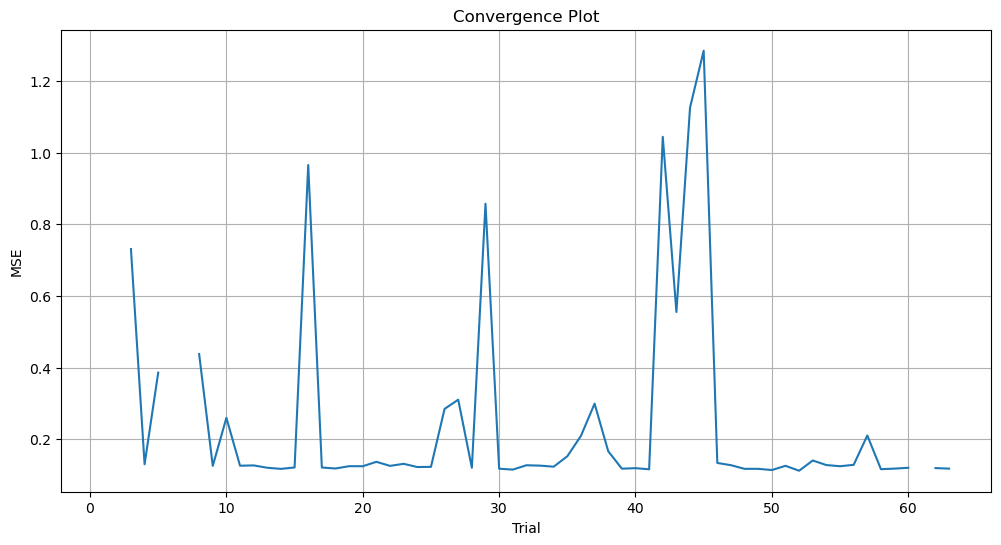

Rank 1:
MSE: 0.11206220179351678
Parameters: {'lstm_epochs': 50, 'lstm_batch_size': 64, 'lstm_n_layers': 3, 'lstm_units': 100, 'lstm_dropout': 0.2, 'lstm_learning_rate': 0.001}

Rank 2:
MSE: 0.11400420234532047
Parameters: {'lstm_epochs': 150, 'lstm_batch_size': 64, 'lstm_n_layers': 3, 'lstm_units': 150, 'lstm_dropout': 0, 'lstm_learning_rate': 0.001}

Rank 3:
MSE: 0.11514619797294208
Parameters: {'lstm_epochs': 150, 'lstm_batch_size': 32, 'lstm_n_layers': 3, 'lstm_units': 150, 'lstm_dropout': 0, 'lstm_learning_rate': 0.001}

Rank 4:
MSE: 0.11610995511502202
Parameters: {'lstm_epochs': 150, 'lstm_batch_size': 64, 'lstm_n_layers': 3, 'lstm_units': 150, 'lstm_dropout': 0, 'lstm_learning_rate': 0.001}

Rank 5:
MSE: 0.11628718806798355
Parameters: {'lstm_epochs': 50, 'lstm_batch_size': 64, 'lstm_n_layers': 3, 'lstm_units': 100, 'lstm_dropout': 0.2, 'lstm_learning_rate': 0.001}

Rank 6:
MSE: 0.11721541890787243
Parameters: {'lstm_epochs': 150, 'lstm_batch_size': 512, 'lstm_n_layers': 3, 'ls

In [10]:
#参数优化结果查看
region = 'I'#
storage_name = f"sqlite:///{country}_{modelname}_region{region}.db" # 生成的调参记录在你写代码的文件夹
study_name =f"{country}_{modelname}_region{region}"
study =optuna.load_study(study_name=study_name, storage=storage_name)
# 输出最佳超参数
print('Best parameters: ', study.best_params)
print('Best MSE: ', study.best_value)

# 加载已经存在的 study
optuna.visualization.plot_param_importances(study)
plt.show()
# 可视化收敛性
df = study.trials_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(df['number'], df['value'])
plt.xlabel('Trial')
plt.ylabel('MSE')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

# 提取所有已完成且有效的试验（按MSE升序排列）
sorted_trials = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None],
    key=lambda x: x.value
)

# 取前10个最佳试验
top_10_trials = sorted_trials[:10]

# 提取参数和MSE值
top_10_results = [{
    "params": trial.params,
    "mse": trial.value
} for trial in top_10_trials]

# 打印前10名结果
for i, result in enumerate(top_10_results, 1):
    print(f"Rank {i}:")
    print(f"MSE: {result['mse']}")
    print(f"Parameters: {result['params']}\n")

In [ ]:
'''

 #############比较预测模型精度是否比ZeroR算法更好#######################################
Test_year = Forecastyear
data1 = data[['year','actual_yield','idJoin']].pivot(index='idJoin', columns='year', values='actual_yield')
train_df = data1.iloc[:,0:Forecastyear-startyear]
test_df = data1.loc[:,Forecastyear]

train_means = train_df.mean(axis=1)
combined = pd.concat([train_means.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)
combined_cleaned = combined.dropna()  # 去除任何包含 NaN 的行
combined_cleaned.columns = ['predicts','records']

os.makedirs(folder_path, exist_ok=True)
filename = os.path.join(folder_path,f'null model scatter in {region} in {Forecastyear}.tiff')
plt_scatter(combined_cleaned,filename) # 绘制预测散点图
# 按照置换话绘制因子重要性
'''



